<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Benchmark_(Xception)_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [2]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [4]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [5]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [6]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Sat Oct 25 09:05:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [7]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling.zip"

In [8]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [9]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "Xception" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "FineTuning" # <= Fine-Tuned หรือ Feature Extraction
ROUND_NUM = 1 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [10]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [11]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling.zip -d /content/ham10000Dataset

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030998_aug_1449.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0029731_aug_490.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0031961.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030812_aug_902.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030369_aug_2134.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0026958_aug_2635.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0032179.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0033709_aug_2407.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030173_aug_2008.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0026844_aug_1881.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0030318.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0033322_aug_884.jpg  
  inflating: /content/ham10000Dataset/train/bkl/ISIC_0025810_

In [12]:
DATASET_DIR = "/content/ham10000Dataset"

## **Section 2: Preprocessing and augmentaion images**

### **Define constant configuration**

In [13]:
def build_model(input_shape, num_classes, model_name, trainable=True):
    """
        สำหรับเลือก Model ที่จะนำมาทดสอบ Benchmark
        Args:
            input_shape: input ที่จะส่งเข้าโมเดล (H, W, C)
            num_classes: จำนวนคลาสที่ใช้ใน Last FC Layer
            model_name: ชื่อโมเดลที่จะใช้
            trainable: bool บ่งบอกว่าจะ Unfreeze หรือไม่ Unfreeze
        Return:
            model: Keras Functional
            preprocess_input: Preprocessing function สำหรับ Normalize ของแต่ละ Pretrained
    """
    if model_name == "Xception":
        base_model = keras.applications.Xception(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.xception.preprocess_input

    elif model_name == "ResNet50":
        base_model = keras.applications.ResNet50(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.resnet50.preprocess_input

    elif model_name == "MobileNetV3Large":
        base_model = keras.applications.MobileNetV3Large(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input

    elif model_name == "VGG16":
        base_model = keras.applications.VGG16(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.vgg16.preprocess_input

    elif model_name == "InceptionV3":
        base_model = keras.applications.InceptionV3(
            include_top = False,
            weights = "imagenet",
            input_shape = input_shape
        )
        preprocess_input = keras.applications.inception_v3.preprocess_input

    for layer in base_model.layers:
        layer.trainable = trainable

    x = base_model.output

    # Classification Head
    x = keras.layers.GlobalAveragePooling2D(name = "avg_pool")(x)
    x = keras.layers.Dense(128, activation = "relu", name = "fc_1")(x)
    x = keras.layers.Dropout(0.5, name = "dropout_1")(x)
    preditions = keras.layers.Dense(num_classes, activation = "softmax", name = "predictions")(x)

    model = keras.models.Model(inputs = base_model.input, outputs = preditions)

    return model, preprocess_input

In [14]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 64
EPOCHS = 30

### **Load dataset**

In [15]:
ds_train = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED
)

ds_val = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/val",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False
)

ds_test = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/test",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 23464 files belonging to 7 classes.
Found 2504 files belonging to 7 classes.
Found 2504 files belonging to 7 classes.


In [16]:
all_classes = ds_train.class_names + ds_val.class_names + ds_test.class_names
class_names = sorted(list(set(all_classes)))
idx_to_class = {i: name for i, name in enumerate(class_names)}

NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 7
Class names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [17]:
model, preprocess_input = build_model(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    model_name=MODEL_NAME,
    trainable=True
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.4),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4),
], seed=SEED)

In [19]:
def apply_preprocess_transform(image, label, preprocess_input=None, transform=None):
    """
        สำหรับ Apply preprocess function และ transfromation จาก albumentation library
        Args:
            image: image tensor จาก keras.utils.image_dataset_from_directory
            label: label กำกับภาพ
            preprocess_input: preprocess function จาก pretreained model (optional) หากตั้งเป็น None จะ 1./255 โดยอัตโนมติ
            transform: transformation จาก albumentation library (optional)
        Return:
            image: image ที่ผ่านการ preprocess และ transformation แล้ว
    """
    def _transform(image_tensor):
        image_np = image_tensor.numpy()
        image_np = image_np.astype(np.uint8)

        if transform:
            image_np = transform(image=image_np)["image"]
        return image_np

    image = tf.py_function(
        func=_transform,
        inp=[image],
        Tout=tf.uint8
    )

    image.set_shape([IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    image = tf.cast(image, tf.float32)

    if preprocess_input:
        image = preprocess_input(image)
    else:
        image = image / 255.0

    return image, label

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
def map_train(x, y):
    return apply_preprocess_transform(
        x, y, preprocess_input=preprocess_input, transform=transform,
    )
def map_val_test(x, y):
    return apply_preprocess_transform(
        x, y, preprocess_input=preprocess_input, transform=None,
    )

In [21]:
train_pipeline = (
    ds_train
    .cache()
    .shuffle(buffer_size=1024)
    .map(map_train, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_pipeline = (
    ds_val
    .cache()
    .map(map_val_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_pipeline = (
    ds_test
    .cache()
    .map(map_val_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## **Section 3: Preparing the model**

### **Define callback function**

In [22]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 5,
    mode = "max",
    min_lr = 1e-06,
    verbose = 1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = MODEL_CHECKPOINT_PATH,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
) # Model checkpoint for save best model file

tensorboard = keras.callbacks.TensorBoard(
    log_dir = MODEL_TENSORBOARD_PATH,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard]

### **Model parameters**

In [23]:
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-04,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-08
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [keras.metrics.CategoricalAccuracy(name="accuracy")]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 21,070,127 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Section 4: Training the model**

In [24]:
training_start = time.time()

history = model.fit(
    train_pipeline,
    validation_data = val_pipeline,
    epochs = EPOCHS,
    callbacks = callback_list,
    verbose = 1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5745 - loss: 1.1320
Epoch 1: val_accuracy improved from -inf to 0.81789, saving model to /content/drive/MyDrive/CP461/mainProject/models/Xception_FineTuning_Adam_1/Xception_best.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.5750 - loss: 1.1309 - val_accuracy: 0.8179 - val_loss: 0.5284 - learning_rate: 1.0000e-04
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9156 - loss: 0.2503
Epoch 2: val_accuracy improved from 0.81789 to 0.82947, saving model to /content/drive/MyDrive/CP461/mainProject/models/Xception_FineTuning_Adam_1/Xception_best.keras
367/367 ━━━━━━━━━━━━━━━━━━━━ 329s 895ms/step - accuracy: 0.9157 - loss: 0.2502 - val_accuracy: 0.8295 - val_loss: 0.5971 - learning_rate: 1.0000e-04
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9672 - loss: 0.1000
Epoch 3: val_accuracy improved from 0.82947 to 0.83946, saving model to /content/drive/MyDrive/CP461/mainProject/

### **Save the model config**

In [25]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/Xception_FineTuning_Adam_1/Xception_history.csv


In [26]:
# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/Xception_FineTuning_Adam_1/Xception.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/Xception_FineTuning_Adam_1/Xception.h5


In [27]:
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmpax0478i1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135207608159888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606010512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606016464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606009936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606017040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606010320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606010128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606016848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606010704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606018000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135207606017424

## **Section 5: Evaluation the model**

In [29]:
tess_loss, tess_acc = model.evaluate(test_pipeline)
print(f"Final test loss: {tess_loss:.4f}")
print(f"Final test accuracy: {tess_acc:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - accuracy: 0.7647 - loss: 1.6208
Final test loss: 0.8856
Final test accuracy: 0.8594


In [30]:
y_pred_prob = model.predict(test_pipeline)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in test_pipeline:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step


In [31]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (2504,)
y_true shape: (2504,)
y_pred_onehot shape: (2504, 7)
y_true_onehot shape: (2504, 7)


### **Top-1 and Top-5 accuracy**

In [32]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8594
Top-1 Error: 0.1406
Top-5 Accuracy: 0.9976
Top-5 Error: 0.0024


### **Classification Report**

In [33]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

precision    recall  f1-score      support
akiec          0.822222  0.456790  0.587302    81.000000
bcc            0.814159  0.718750  0.763485   128.000000
bkl            0.688073  0.818182  0.747508   275.000000
df             0.923077  0.827586  0.872727    29.000000
mel            0.699571  0.584229  0.636719   279.000000
nv             0.914832  0.941562  0.928005  1677.000000
vasc           0.941176  0.914286  0.927536    35.000000
accuracy       0.859425  0.859425  0.859425     0.859425
macro avg      0.829016  0.751627  0.780469  2504.000000
weighted avg   0.858265  0.859425  0.855648  2504.000000

### **Training and Validation curve**

In [34]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    """
        สำหรับ Plot training and validation curve สำหรับ accuracy และ loss
        Args:
            history: ประวัติการ Train ที่ได้จาก model.fit()
            save_path: เซฟภาพเก็บไว้ที่ไหน (optional)
            fontsize: ขนาด font default 16
            title: สำหรับชื่อรูปภาพ (optional)
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

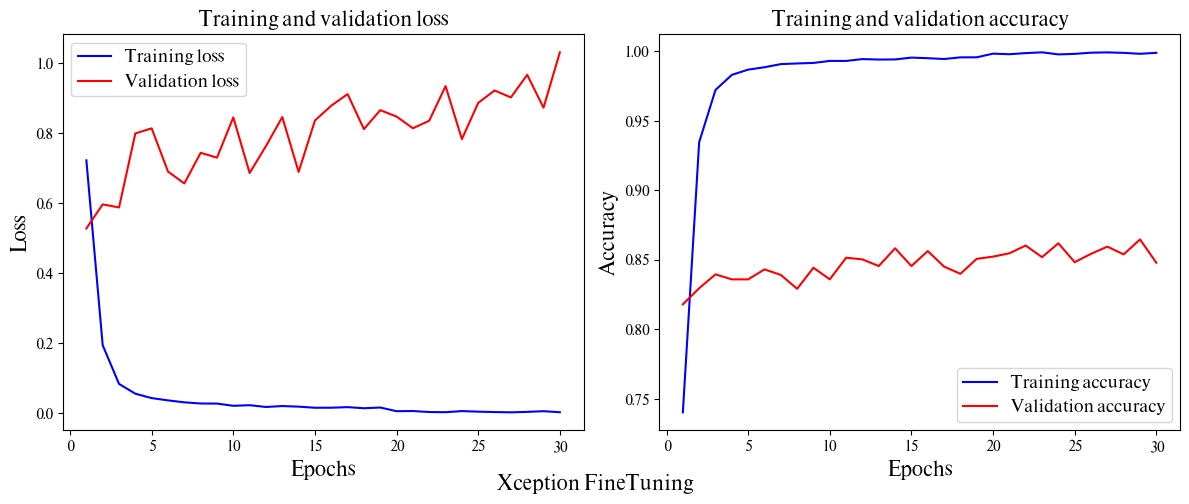

In [35]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_NAME} {TYPE}")

### **Confusion Matrix**

In [36]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    """
        สำหรับ Plot counfusion matrix
        Args:
            cm (array): ค่า confusion matrix ที่ต้องการ plot
            classes (list): รายชื่อคลาส (label names) สำหรับแกน X และ Y
            normalize (bool, default=False): ถ้า True จะทำ normalization ให้ค่าทุกแถวรวมเป็น 1
            title (str, optional): ชื่อกราฟที่จะแสดงด้านบน
            cmap (matplotlib colormap, default=plt.cm.Blues): โทนสีของ heatmap
            save_path (str, optional): โฟลเดอร์ที่จะบันทึกภาพ (ถ้าไม่กำหนดจะไม่บันทึก)
            fontsize (int, default=12): ขนาดตัวอักษรในกราฟ
    """
    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

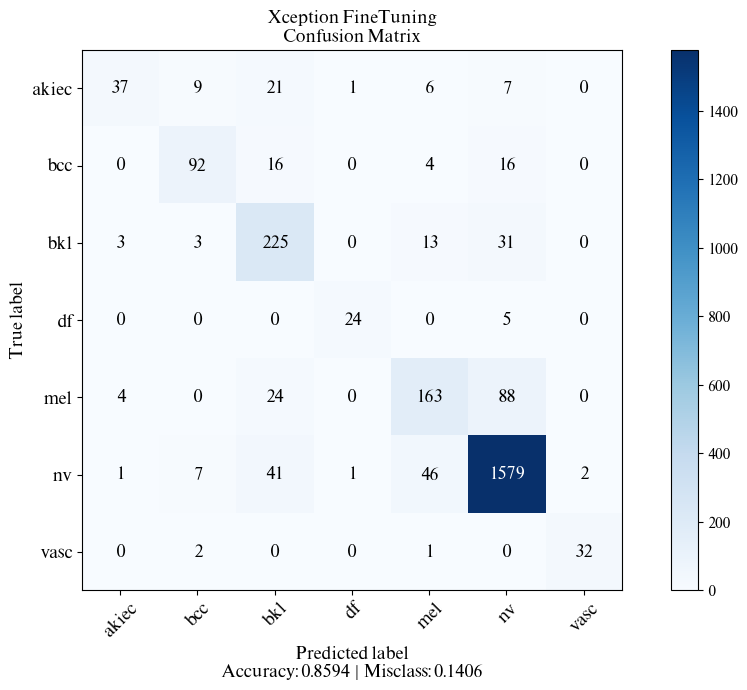

In [37]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

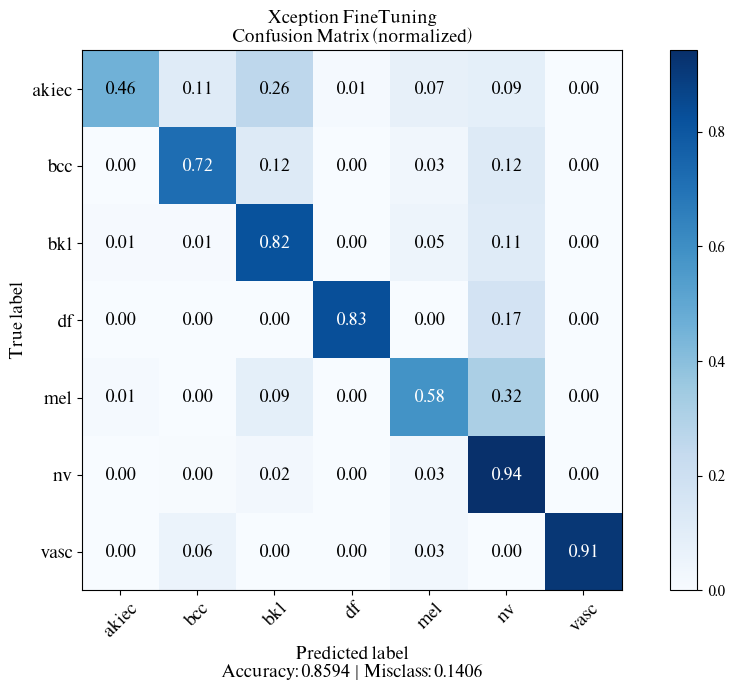

In [38]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_NAME} {TYPE}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [39]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    """
        y_true_onehot (ndarray): ค่า ground truth ในรูปแบบ one-hot encoded (ขนาด n_samples × n_classes)
        y_pred_prob (ndarray): ค่าความน่าจะเป็นที่โมเดลทำนาย (ขนาดเดียวกันกับ y_true_onehot)
        class_names (list): รายชื่อคลาสแต่ละคลาสที่ใช้แสดงในกราฟ
        title (str, optional): ชื่อกราฟ (ถ้าไม่ระบุจะใช้ชื่อเริ่มต้น “Receiver Operating Characteristic (ROC) - Multiclass”)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg)
        fontsize (int, default=14): ขนาดตัวอักษรในกราฟ
    """
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

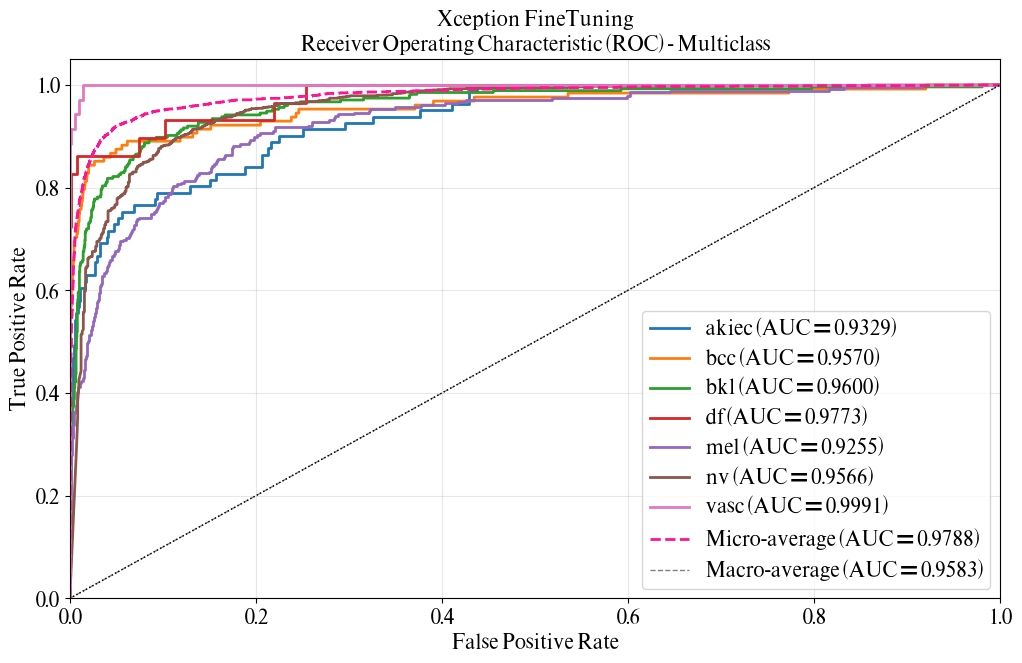

In [40]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_NAME} {TYPE}", ASSETS_FOR_MODEL_PATH)

## **Section 6: Explainable AI (XAI)**

In [41]:
def prepare_unique_image_from_dataset(dataset, y_pred, idx_to_class,
                                      img_size=(224, 224),
                                      num_images=7,
                                      random_state=42):
    """
        dataset (tf.data.Dataset): ชุดข้อมูลภาพและ label (เช่น test set หรือ validation set)
        y_pred (array-like): ผลการทำนายของโมเดล (เป็น index ของคลาสที่คาดว่าใช่)
        idx_to_class (dict): mapping จาก index → ชื่อคลาสจริง เช่น {0: "Cat", 1: "Dog"}
        img_size (tuple, default=(224, 224)): ขนาดภาพที่ต้องการ (ไม่ได้ใช้ในการ resize ที่นี่ แต่เป็นข้อมูลอ้างอิง)
        num_images (int, default=7): จำนวนภาพที่จะสุ่มเลือกมาแสดง (สูงสุด 1 ภาพต่อคลาส)
        random_state (int, default=42): ค่า seed สำหรับการสุ่ม เพื่อให้ผลลัพธ์ reproducible
    """

    images_all = []
    labels_all = []

    for img, label in dataset:
        images_all.append(img.numpy())
        labels_all.append(np.argmax(label.numpy()))

    images_all = np.array(images_all)
    labels_all = np.array(labels_all)

    unique_classes = np.unique(labels_all)
    if len(unique_classes) < num_images:
        num_images = len(unique_classes)

    rng = np.random.default_rng(random_state)
    sampled_indices = []
    for cls in unique_classes:
        cls_indices = np.where(labels_all == cls)[0]
        sampled_idx = rng.choice(cls_indices, size=1, replace=False)
        sampled_indices.extend(sampled_idx)

    if len(sampled_indices) > num_images:
        sampled_indices = rng.choice(sampled_indices, size=num_images, replace=False)

    image_array = []
    pred_titles = []
    true_titles = []

    for idx in sampled_indices:
        img = images_all[idx]
        image_array.append(img.astype(np.uint8))
        true_idx = labels_all[idx]
        pred_idx = y_pred[idx]
        true_titles.append(idx_to_class[true_idx])
        pred_titles.append(idx_to_class[pred_idx])

    return image_array, pred_titles, true_titles

In [42]:
image_array, pred_titles, true_titles = prepare_unique_image_from_dataset(
    dataset=ds_test,
    y_pred=y_pred,
    idx_to_class=idx_to_class,
    img_size=IMAGE_SIZE,
    num_images=NUM_CLASSES,
    random_state=SEED
)

In [43]:
def visualize_image_predict(image_array, pred_title, true_title,
                            title, save_path=None, fontsize=16,
                            num_rows=2, alpha=0.5):
    """
    แสดงภาพตัวอย่างพร้อมผลการทำนายของโมเดล

    ฟังก์ชันนี้ใช้สำหรับแสดงภาพตัวอย่างจากชุดข้อมูล พร้อมชื่อคลาสที่โมเดลทำนายได้
    และชื่อคลาสจริง โดยจะทำการเปรียบเทียบผลลัพธ์และไฮไลต์สีของชื่อภาพ:
    - สีเขียว: ทำนายถูกต้อง
    - สีแดง: ทำนายผิด

    Args:
        image_array (list[np.ndarray]): ลิสต์ของภาพ (ชนิด uint8) ที่ต้องการแสดงผล
        pred_title (list[str]): รายชื่อคลาสที่โมเดลทำนายได้สำหรับแต่ละภาพ
        true_title (list[str]): รายชื่อคลาสจริงของแต่ละภาพ
        title (str): ชื่อเรื่องหลักของกราฟ (จะถูกต่อท้ายด้วย "Visualize Image Predict")
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ
        fontsize (int, default=16): ขนาดตัวอักษรที่ใช้ในกราฟ
        num_rows (int, default=2): จำนวนแถวของ subplot (แต่ในโค้ดนี้จะถูกตั้งค่าเป็น 1 โดยอัตโนมัติ)
        alpha (float, default=0.5): ค่าความโปร่งใส
    """

    pic_title = f"{title} Visualize Image Predict"

    num_images = len(image_array)
    num_rows = 1
    fig, axes = plt.subplots(num_rows, num_images, figsize=(22, 4))

    if num_images == 1:
        ax_flat = [axes]
    else:
        ax_flat = axes.flatten()

    for i in range(num_images):
        img = image_array[i]
        pred = pred_title[i]
        true = true_title[i]

        is_correct = (pred == true)
        title_color = "green" if is_correct else "red"
        sub_title = f"Predict: {pred} | True Label: {true}"

        ax_flat[i].imshow(img.astype(np.uint8))
        ax_flat[i].set_title(sub_title, color=title_color, fontsize=fontsize)
        ax_flat[i].axis("off")

    for j in range(num_images, len(ax_flat)):
        ax_flat[j].axis("off")

    fig.suptitle(pic_title, fontsize=fontsize + 2, fontweight="bold", y=1.0)
    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}/image_predict.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/image_predict.svg", format="svg", bbox_inches="tight")

    plt.show()

### **Visualize image prediction**

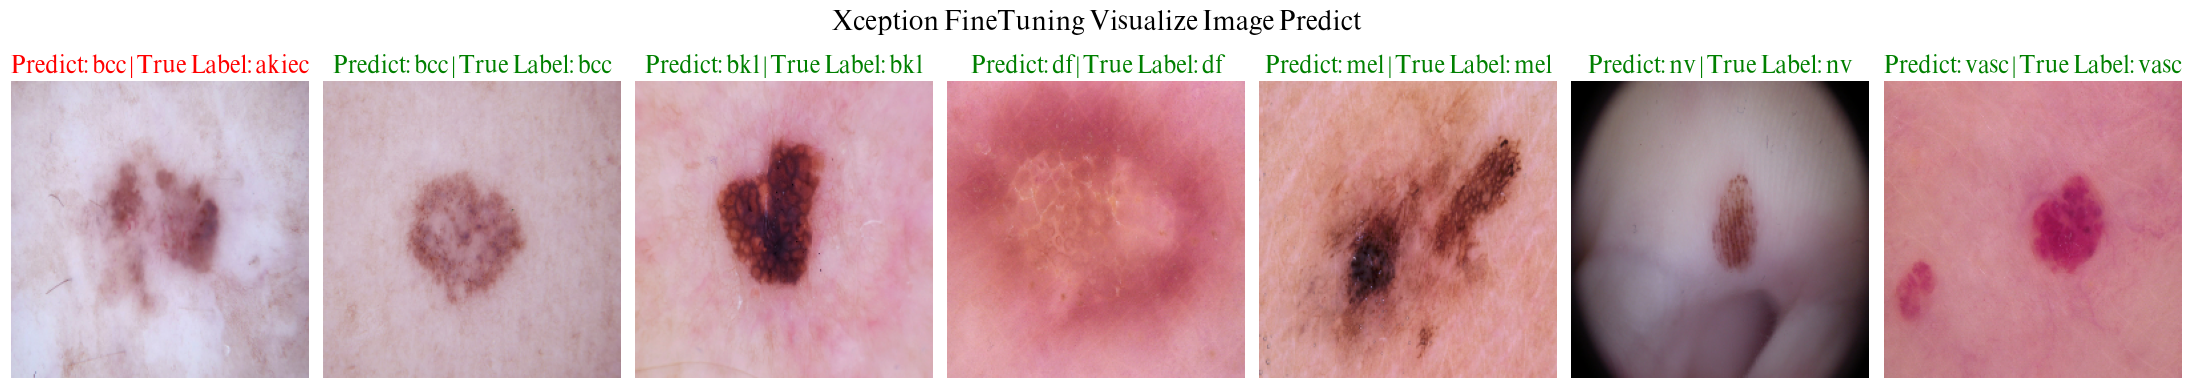

In [44]:
visualize_image_predict(
    image_array,
    pred_titles,
    true_titles,
    title=f"{MODEL_NAME} {TYPE}",
    save_path=ASSETS_FOR_MODEL_PATH,
    fontsize=16)

In [45]:
def model_modifier_fucntion(model):
    cloned_model = keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())
    cloned_model.layers[-1].activation = keras.activations.linear
    return cloned_model

def score_function(output):
    return (output[0][1][2][3][4][5][6]) # ต้องมีจำนวนเท่ากับจำนวนกับ Class โดย Start Index ที่ 0

replace_to_linear = ReplaceToLinear()
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6]) # ต้องมีจำนวนเท่ากับจำนวนกับ Class โดย Start Index ที่ 0

seed_input = preprocess_input(np.array(image_array))
clone_model = model_modifier_fucntion(model)
scorecam = Scorecam(clone_model, model_modifier=replace_to_linear)

cam = scorecam(score,
               seed_input,
               penultimate_layer=-1,
               max_N=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step


In [46]:
saliency = Saliency(
    model,
    model_modifier=replace_to_linear,
    clone=True
)

saliency_map = saliency(
    score,
    seed_input.astype(np.float32),
    smooth_samples=20,
    smooth_noise=0.20
)

### **Visualize FasterScore Cam**

In [47]:
def visualize_faster_score_cam(image_array, cam_results, pred_title,
                            true_title, title, save_path=None,
                            fontsize=16, alpha=0.5):

    """
    แสดงภาพพร้อม Heatmap ของ Faster Score-CAM

    ฟังก์ชันนี้ใช้สำหรับแสดงภาพตัวอย่างพร้อม heatmap ของ Faster Score-CAM
    เพื่อดูว่าโมเดลให้ความสำคัญกับบริเวณใดของภาพในการทำนายคลาส
    ชื่อคลาสของแต่ละภาพจะถูกไฮไลต์:
    - สีเขียว: ทำนายถูกต้อง
    - สีแดง: ทำนายผิด

    Args:
        image_array (list[np.ndarray]): ลิสต์ของภาพที่ต้องการแสดงผล (uint8)
        cam_results (list[np.ndarray]): ลิสต์ของ heatmap ของ Score-CAM สำหรับแต่ละภาพ
        pred_title (list[str]): รายชื่อคลาสที่โมเดลทำนายได้
        true_title (list[str]): รายชื่อคลาสจริงของแต่ละภาพ
        title (str): ชื่อเรื่องหลักของกราฟ (จะแสดงต่อท้ายใน suptitle)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg) หากไม่ระบุ จะไม่บันทึกไฟล์
        fontsize (int, default=16): ขนาดตัวอักษรของ title
        alpha (float, default=0.5): ความโปร่งใสของ heatmap
    """

    pic_title = f"Faster Score-CAM Applied on {title}"
    num_images = len(image_array)
    num_rows = 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_images, figsize=(22, 4))
    ax_flat = axes.flatten()

    for i in range(num_images):
        heatmap = np.uint8(plt.cm.jet(cam_results[i])[..., :3] * 255) # Corrected cm.jet to plt.cm.jet
        pred = pred_title[i]
        true = true_title[i]

        is_correct = (pred == true)
        title_color = "green" if is_correct else "red"
        title = f"Pred: {pred} | True: {true}"

        ax_flat[i].imshow(image_array[i])
        ax_flat[i].imshow(heatmap, cmap="jet", alpha=alpha)

        ax_flat[i].set_title(title, fontsize=fontsize, color=title_color)
        ax_flat[i].axis("off")

    for j in range(num_images, len(ax_flat)):
        ax_flat[j].axis("off")

    plt.tight_layout()
    fig.suptitle(pic_title, fontsize=fontsize + 2, fontweight="bold", y=1.02)
    if save_path:
        plt.savefig(f"{save_path}/faster_score_cam.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/faster_score_cam.svg", format="svg", bbox_inches="tight")
    plt.show()

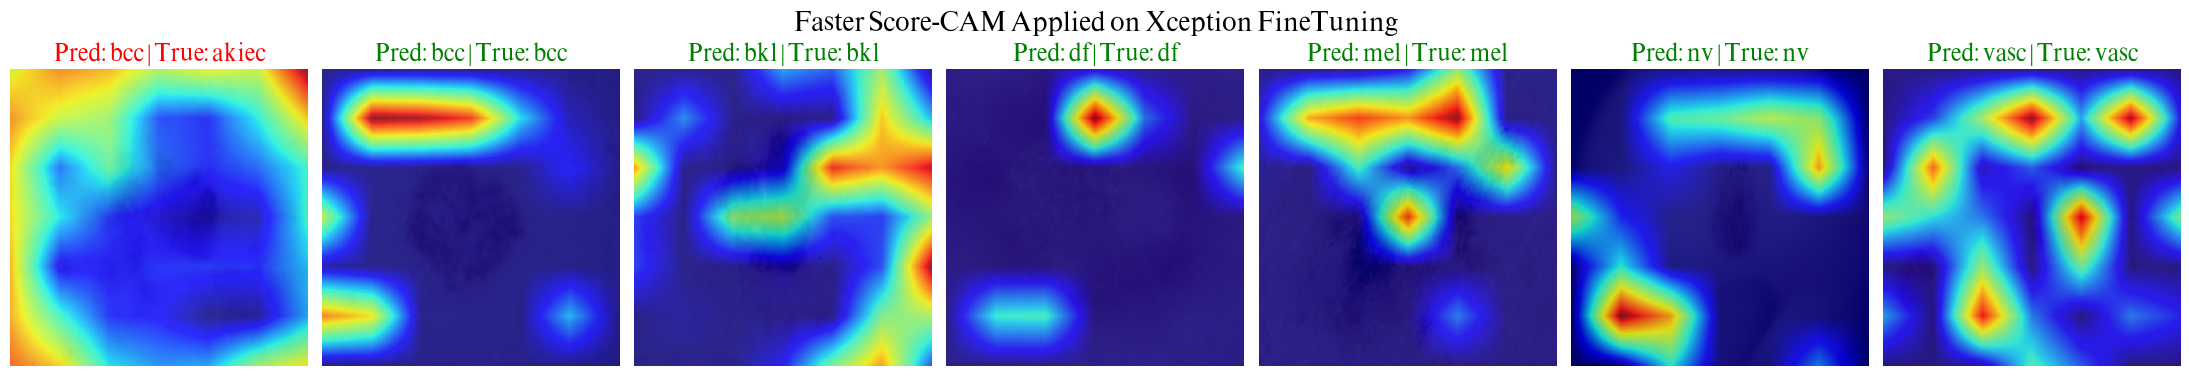

In [48]:
visualize_faster_score_cam(
    image_array=image_array,
    cam_results=cam,
    pred_title=pred_titles,
    true_title=true_titles,
    title=f"{MODEL_NAME} {TYPE}",
    save_path=ASSETS_FOR_MODEL_PATH,
    fontsize=16,
    alpha=0.8
)

### **Visualize Smooth Cam**

In [49]:
def visualize_smooth_grad(image_array, saliency_map, pred_title,
                          true_title, title, save_path=None, fontsize=16):

    """
    แสดงภาพพร้อม Saliency Map ของ SmoothGrad

    ฟังก์ชันนี้ใช้สำหรับแสดงภาพตัวอย่างพร้อม saliency map จาก SmoothGrad
    เพื่อดูว่าพิกเซลส่วนใดของภาพที่โมเดลให้ความสำคัญในการทำนายคลาส
    ชื่อคลาสของแต่ละภาพจะถูกไฮไลต์:
    - สีเขียว: ทำนายถูกต้อง
    - สีแดง: ทำนายผิด

    Args:
        image_array (list[np.ndarray]): ลิสต์ของภาพที่ต้องการแสดงผล (uint8)
        saliency_map (list[np.ndarray]): ลิสต์ของ saliency map สำหรับแต่ละภาพ
        pred_title (list[str]): รายชื่อคลาสที่โมเดลทำนายได้
        true_title (list[str]): รายชื่อคลาสจริงของแต่ละภาพ
        title (str): ชื่อเรื่องหลักของกราฟ (จะแสดงต่อท้ายใน suptitle)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ
        fontsize (int, default=16): ขนาดตัวอักษรของ title
    """

    pic_title = f"SmoothGrad Applied on {title}"
    num_images = len(image_array)
    num_rows = 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_images, figsize=(22, 4))
    ax_flat = axes.flatten()

    for i in range(num_images):
        pred = pred_title[i]
        true = true_title[i]

        is_correct = (pred == true)
        title_color = "green" if is_correct else "red"
        title = f"Pred: {pred} | True: {true}"

        ax_flat[i].imshow(image_array[i])
        ax_flat[i].imshow(saliency_map[i], cmap="jet")
        ax_flat[i].set_title(title, fontsize=fontsize, color=title_color)
        ax_flat[i].axis("off")

    for j in range(num_images, len(ax_flat)):
        ax_flat[j].axis("off")

    plt.tight_layout()
    fig.suptitle(pic_title, fontsize=fontsize + 2, fontweight="bold", y=1.02)
    if save_path:
        plt.savefig(f"{save_path}/smooth_grad.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/smooth_grad.svg", format="svg", bbox_inches="tight")
    plt.show()

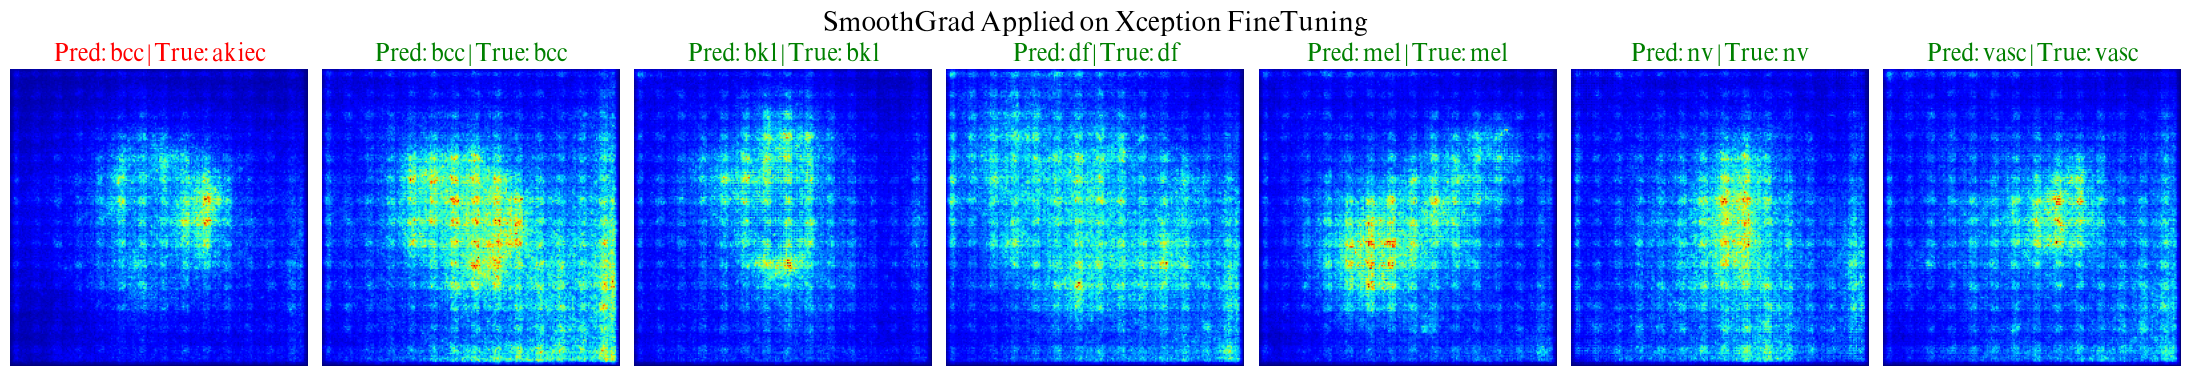

In [50]:
visualize_smooth_grad(
    image_array=image_array,
    saliency_map=saliency_map,
    pred_title=pred_titles,
    true_title=true_titles,
    title=f"{MODEL_NAME} {TYPE}",
    save_path=ASSETS_FOR_MODEL_PATH,
    fontsize=16
)